In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'
import astropy.units as u

In [2]:
from astropy.io import fits

In [3]:
cross = Table.read('sourcefiles.csv')
cross2 = Table.read('part2files.csv')

full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
summ = pd.read_csv('summtab.csv')

cross2 = join(cross2,full,keys='src_n')

In [4]:
phase = pd.read_csv('phasetab.csv')

In [26]:
def sf(name,dpi=200):
    plt.savefig(f'Figs/{name}',dpi=dpi,bbox_inches='tight')

# Quick Spin Period Plot Follow-Up

In [5]:
#just part 1 sources
p1 = summ[summ['Part']==1]

In [209]:
p2 = summ[summ['Part']==2] #part 2 sources: no spin period

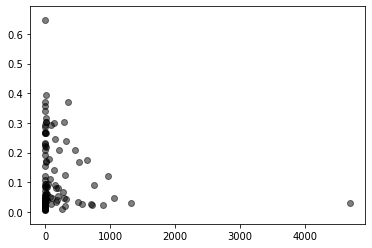

In [6]:
#WRONG PLOT -- had p2 at 0s
plt.scatter(summ['spin period'],summ['stdev I'],color='black',alpha=0.5)

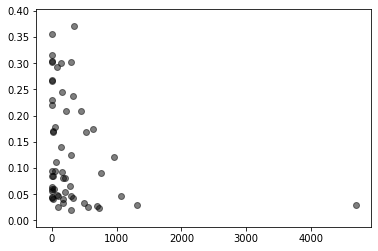

In [7]:
#only looks like a log scale trend above 100s 
plt.scatter(p1['spin period'],p1['stdev I'],color='black',alpha=0.5)
# plt.xscale('log')
# plt.xlim(100,10000)

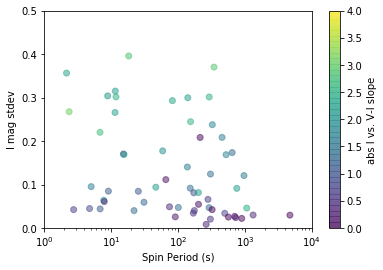

In [25]:
#log scale with color as slope
#works for slope but not correlation coefficient
plt.scatter(summ['spin period'],summ['stdev I'],c=np.abs(summ['I V-I slope']),alpha=0.5,vmax=4)
plt.colorbar(label='abs I vs. V-I slope')
plt.xscale('log')
plt.xlim(1,10000)
plt.xlabel('Spin Period (s)')
plt.ylabel('I mag stdev')
plt.ylim(0,0.5)
# plt.savefig('Figs/stdevspin_log.png',dpi=150,bbox_inches='tight')

Text(0, 0.5, 'I mag stdev')

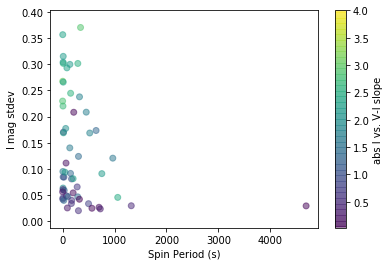

In [9]:
#repeat without log scale
plt.scatter(p1['spin period'],p1['stdev I'],c=np.abs(p1['I V-I slope']),alpha=0.5,vmax=4)
plt.colorbar(label='abs I vs. V-I slope')
# plt.xscale('log')
# plt.xlim(1,10000)
plt.xlabel('Spin Period (s)')
plt.ylabel('I mag stdev')
# plt.savefig('Figs/stdevspin_updated.png',dpi=150,bbox_inches='tight')

(-100, 1400)

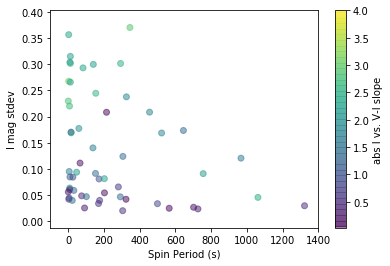

In [10]:
#does it look good at all without spin outlier?
plt.scatter(p1['spin period'],p1['stdev I'],c=np.abs(p1['I V-I slope']),alpha=0.5,vmax=4)
plt.colorbar(label='abs I vs. V-I slope')
# plt.xscale('log')
# plt.xlim(1,10000)
plt.xlabel('Spin Period (s)')
plt.ylabel('I mag stdev')
plt.xlim(-100,1400)
# plt.savefig('Figs/stdevspin_zoom.png',dpi=150,bbox_inches='tight')

Text(0.5, 0, 'I mag stdev')

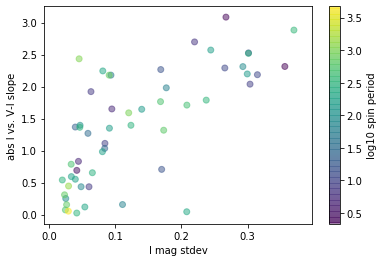

In [36]:
#rotate axes -- harder to tell but looking for those light greens/yellows at low I mag stdev
plt.scatter(p1['stdev I'],np.abs(p1['I V-I slope']),c=np.log10(p1['spin period']),alpha=0.5)
plt.colorbar(label='log10 spin period')
# plt.xscale('log')
# plt.xlim(1,10000)
plt.ylabel('abs I vs. V-I slope')
plt.xlabel('I mag stdev')

Text(0.5, 0, 'I mag stdev')

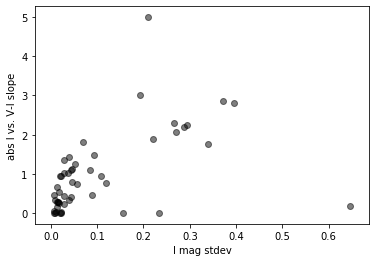

In [210]:
#rotate axes -- harder to tell but looking for those light greens/yellows at low I mag stdev
plt.scatter(p2['stdev I'],np.abs(p2['I V-I slope']),color='black',alpha=0.5)
# plt.xscale('log')
# plt.xlim(1,10000)
plt.ylabel('abs I vs. V-I slope')
plt.xlabel('I mag stdev')
#disproportionate at low I mag stdev (more quiescent) expect some could have long spin period

In [214]:
#spin period in relation to skew and kurtois
zrows = summ[summ['spin period']==0]
zrows['spin period'] = np.nan
summ[summ['spin period']==0] = zrows
phase['spin period'] = summ['spin period']

Text(0.5, 0, 'optical period (days)')

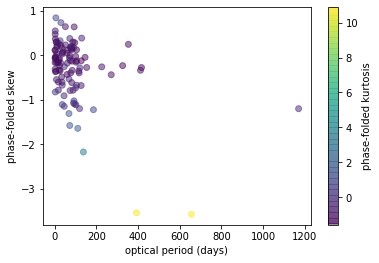

In [232]:
#skew goes down with spin period
plt.scatter(phase['period'],phase['skew'],c=phase['kurtosis'],alpha=0.5)
# plt.xscale('log')
plt.colorbar(label='phase-folded kurtosis')
plt.ylabel('phase-folded skew')
plt.xlabel('optical period (days)')
# sf('skewkurtperiod')

Text(0, 0.5, 'phase-folded kurtosis')

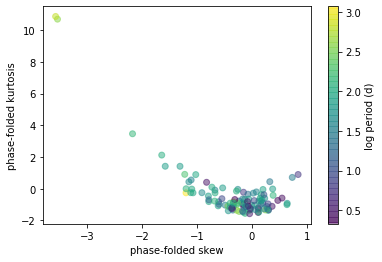

In [234]:
#same but changing axes
plt.scatter(phase['skew'],phase['kurtosis'],c=np.log10(phase['period']),alpha=0.5)
plt.colorbar(label='log period (d)')
plt.xlabel('phase-folded skew')
plt.ylabel('phase-folded kurtosis')

# Re-doing with binning by obsid

### SXP 5.05

I and V-I correlation: -0.7854401757019701
V and V-I correlation: -0.44726007362846626


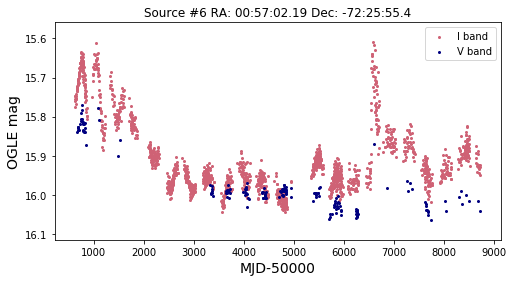

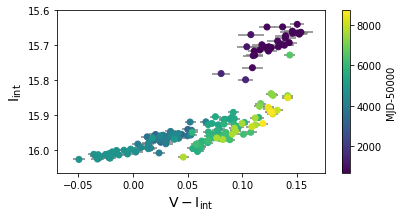

In [197]:
#sxp 5.05
iband,vband = o.getIV(6,cross,stack=True,plot=True)
o.colormag(iband,vband,both=False,figsize=(6,3))

In [201]:
#swift data by observation
s5 = np.loadtxt('Swift_LCs/sxp5.05.txt',skiprows=15,comments='!',usecols=(0,1,2,3,4,5))

In [202]:
#not upper limit
s5_reg = s5[:-69]

In [203]:
date = s5_reg[:,0]-50000
rate = s5_reg[:,3]
rerr = s5_reg[:,4] 
rerr_low = np.abs(s5_reg[:,5])

In [204]:
s5_up = s5[69:]
dup = s5_up[:,0]-50000
rup = s5_up[:,3]

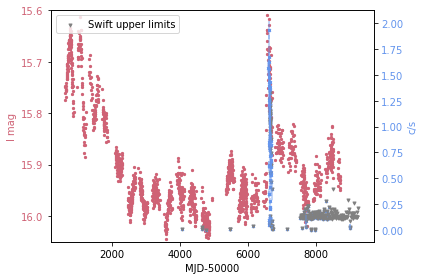

In [207]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(16.05,15.6)
# ax1.set_xlim(7000,9000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],color=color,ls='none',alpha=0.5)
#upper limits
ax2.scatter(dup,rup,color='grey',marker='v',s=9,label='Swift upper limits')
plt.legend()

fig.tight_layout()
sf('src6')

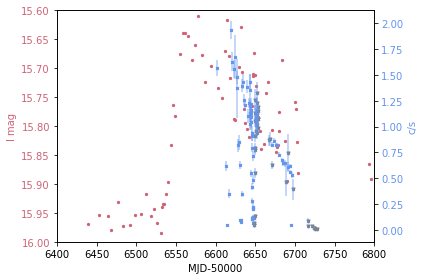

In [208]:
#zoom in on type II
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(16,15.6)
ax1.set_xlim(6400,6800)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],color=color,ls='none',alpha=0.5)
#upper limits
ax2.scatter(dup,rup,color='grey',marker='v',s=9,label='Swift upper limits')

fig.tight_layout()
sf('src6zoom')

### SXP 6.85 (7)

I and V-I correlation: -0.9670343623561133
V and V-I correlation: -0.9225217209125162


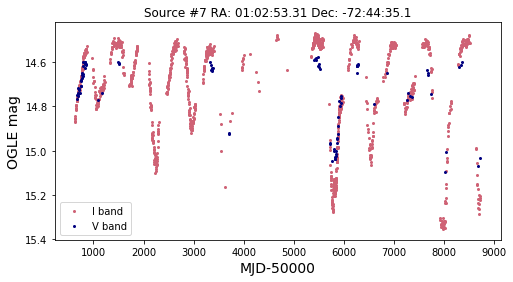

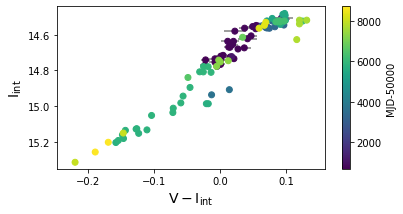

In [188]:
iband,vband = o.getIV(7,cross,stack=True,plot=True)
interp = o.colormag(iband,vband,both=False,figsize=(6,3),retint=True)

In [189]:
#swift data by observation
s6 = np.loadtxt('Swift_LCs/SXP6.85/lc/curve_nosys.qdp',skiprows=15,comments='!',usecols=(0,1,2,3,4,5))

In [190]:
#without upper limits: WT and PC, skipping upper limits for now
s6_reg = np.concatenate([s6[:4],s6[5:69]]) 

In [191]:
#upper limits are other values
#dimensionality gets messed up since only one row in WT upper
wtup = np.concatenate([s6[4:5],s6[4:5]]) #repeating WT upper limit to have right dimensions
s6_up = np.concatenate([wtup,s6[69:]]) 

In [192]:
#used this to trial and error for break points
#more automated would look for discontinuity in MJD
s6[:4,0]

array([59101.56954143, 59103.95834582, 59105.61265102, 59111.38454435])

In [193]:
date = s6_reg[:,0]-50000
rate = s6_reg[:,3]
dup = s6_up[:,0]-50000
rup = s6_up[:,3]

rerr = s6_reg[:,4] 
rerr_low = np.abs(s6_reg[:,5])

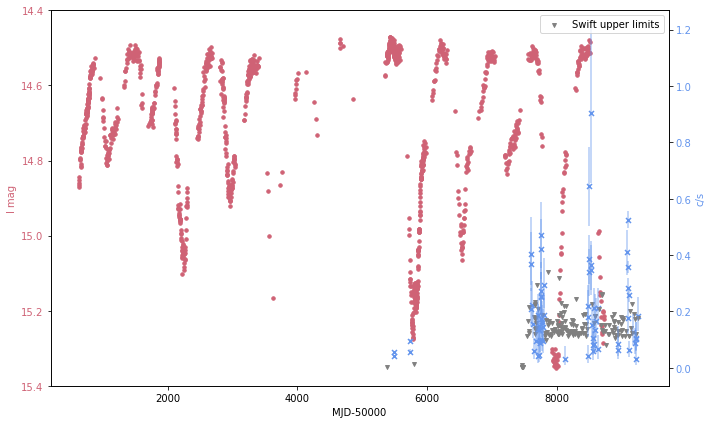

In [194]:
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.4,14.4)
# ax1.set_xlim(7000,9000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits')
ax2.legend()
ax2.errorbar(date,rate,ls='none',color=color,alpha=0.5,yerr=[rerr_low,rerr])
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src7')

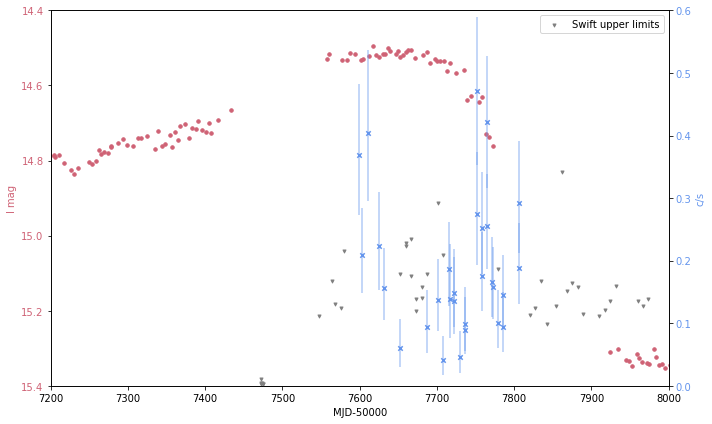

In [195]:
#zoom in on first and add color-mag info
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.4,14.4)
ax1.set_xlim(7200,8000)
#plot interpolated I with color showing V-I
# im = ax1.scatter(vband['MJD-50000'],interp,c=vband['V mag']-interp,vmin=-.24,vmax=.12)
# fig.colorbar(im,label='V-I')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=20,marker='x')
ax2.scatter(dup,rup, color='grey',s=9,marker='v',label='Swift upper limits')
ax2.legend()
ax2.set_ylim(0,.6)
ax2.errorbar(date,rate,ls='none',color=color,alpha=0.5,yerr=[rerr_low,rerr])

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src7zoom1')

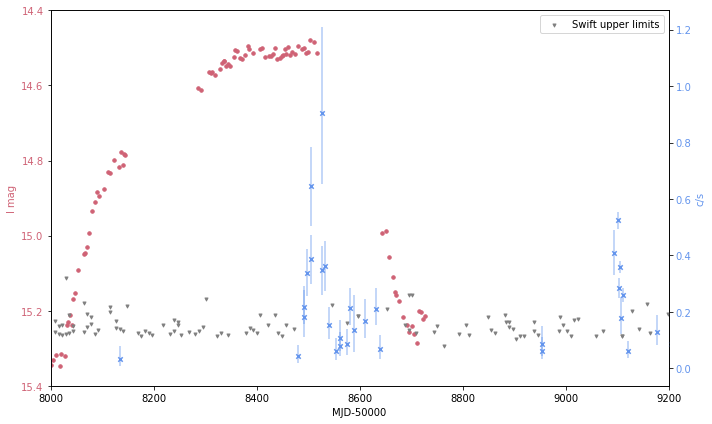

In [196]:
#zoom in on first and add color-mag info
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.4,14.4)
ax1.set_xlim(8000,9200)
#plot interpolated I with color showing V-I; use same color limits as above
# im = ax1.scatter(vband['MJD-50000'],interp,c=vband['V mag']-interp,vmin=-.24,vmax=.12)
# fig.colorbar(im,label='V-I')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=20,marker='x')
ax2.scatter(dup,rup, color='grey',s=9,marker='v',label='Swift upper limits')
ax2.legend()
ax2.errorbar(date,rate,ls='none',color=color,alpha=0.5,yerr=[rerr_low,rerr])

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src7zoom2')

### LIN 198 (9): by snapshot; in seconds?

I and V-I correlation: -0.667340526448103
V and V-I correlation: -0.39477937412506486


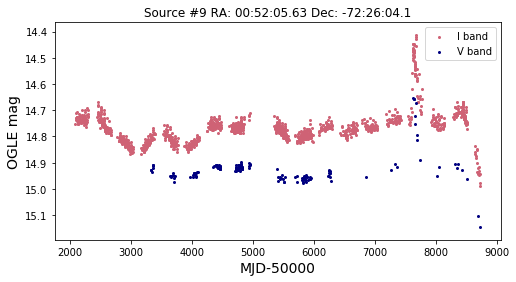

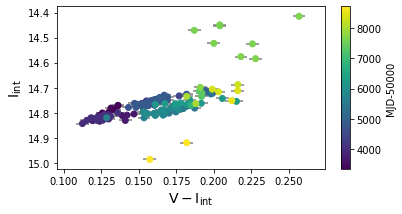

In [180]:
iband,vband = o.getIV(9,cross,stack=True,plot=True)
interp = o.colormag(iband,vband,both=False,figsize=(6,3),retint=True)

In [181]:
#no upper limits (may've set it that way...?)
s9 = np.loadtxt('Swift_LCs/LIN198/curve_nosys.qdp',skiprows=15,comments='!',usecols=(0,1,2,3,4,5))

In [182]:
# evt file uses different reference but can use to check for final
# def readevt(file,index=1,header=False):
#     hdu_list = fits.open(file, memmap=True)
#     if header: tab = hdu_list[index].header
#     else: tab = Table(hdu_list[index].data)
#     return tab
# head = readevt('Swift_LCs/LIN198/wtsourcetotal.evt',index=0,header=True)

In [183]:
date = s9[:,0]
rate = s9[:,3]
rerr = s9[:,4] 
rerr_low = np.abs(s9[:,5])

In [184]:
date = date*u.s.to(u.day)+3683.731273 #took this from previous file -- should be the same

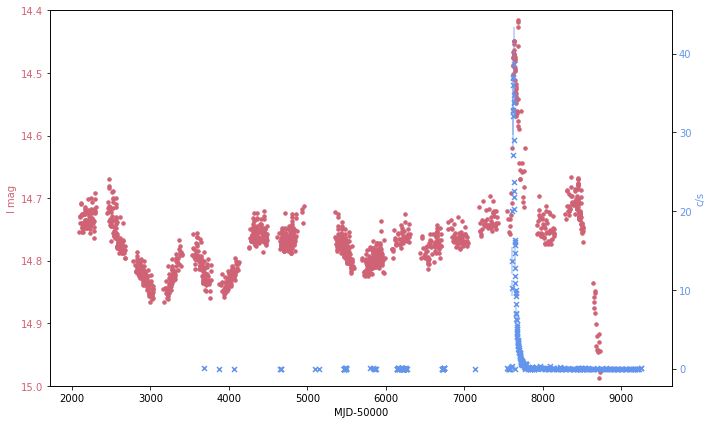

In [186]:
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15,14.4)
# ax1.set_xlim(7000,9000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.errorbar(date,rate,ls='none',color=color,yerr=[rerr_low,rerr],alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src9')

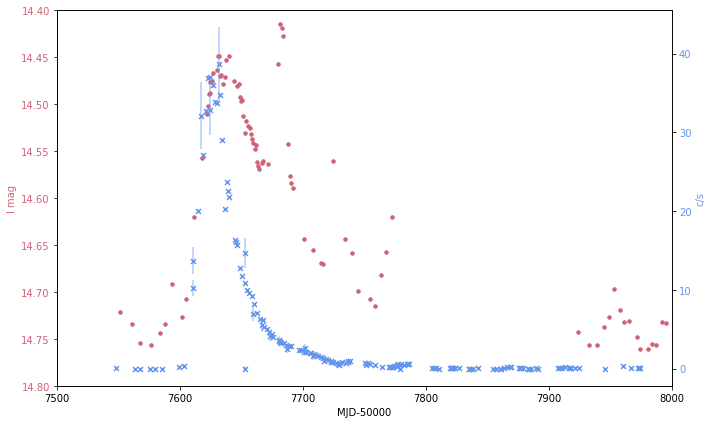

In [187]:
#do three zooms (peaks, peaks, anything at drop?) b/c final peak has no optical
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.8,14.4)
ax1.set_xlim(7500,8000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
# ax2.set_ylim(0,0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(date,rate,ls='none',color=color,yerr=[rerr_low,rerr],alpha=0.5)


fig.tight_layout()
sf('src9zoom1')

### SXP 4.78 (5)

I and V-I correlation: -0.6677821537439047
V and V-I correlation: 0.17975703286765632


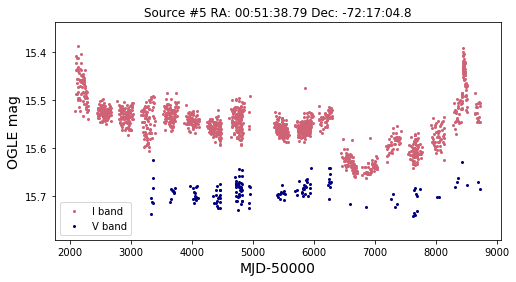

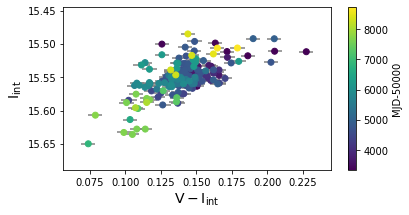

In [170]:
iband,vband = o.getIV(5,cross,stack=True,plot=True)
interp = o.colormag(iband,vband,both=False,figsize=(6,3),retint=True)

In [171]:
s5 = np.loadtxt('Swift_LCs/SXP4.78/lc/curve_nosys.qdp',skiprows=13,comments='!',usecols=(0,1,2,3,4,5))
#includes WT, PC, PC upper limit

In [172]:
s5_reg = s5[:46]
s5_up = s5[46:]

In [173]:
date = s5_reg[:,0]-50000
rate = s5_reg[:,3]
dup = s5_up[:,0]-50000
rup = s5_up[:,3]

In [174]:
rerr = s5_reg[:,4] 
rerr_low = np.abs(s5_reg[:,5])

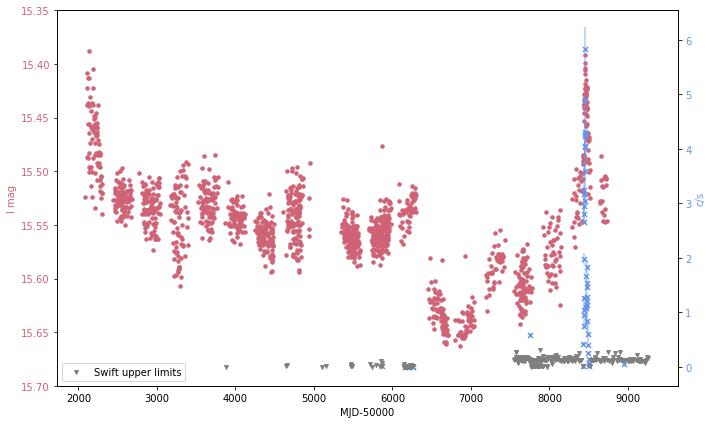

In [178]:
#plot full LC
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.7,15.35)
# ax1.set_xlim(7000,9000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits')
ax2.legend(loc='lower left')
#adding error to rate
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],linestyle='none',color=color,alpha=0.5)

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src5')

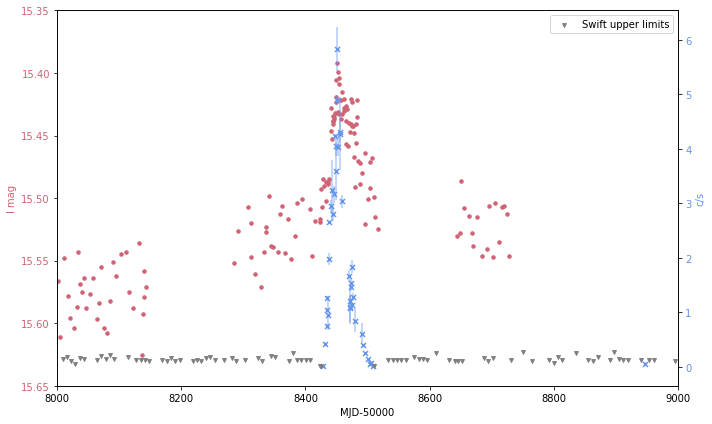

In [179]:
#plot full LC
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.65,15.35)
ax1.set_xlim(8000,9000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits')
ax2.legend()
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],linestyle='none',color=color,alpha=0.5)

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src5_zoom1')

### SXP 756 (60)

I and V-I correlation: -0.7903821327759735
V and V-I correlation: -0.572353612041409


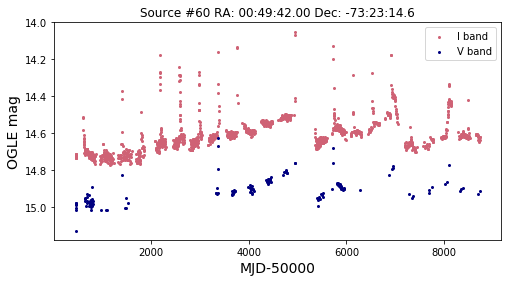

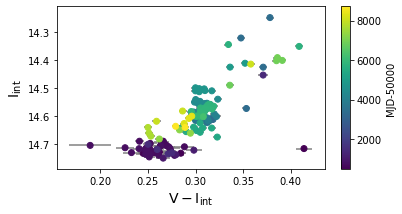

In [127]:
iband,vband = o.getIV(60,cross,stack=True,plot=True)
interp = o.colormag(iband,vband,both=False,figsize=(6,3),retint=True)

In [129]:
s60 = np.loadtxt('Swift_LCs/SXP756/lc/curve_nosys.qdp',skiprows=13,comments='!',usecols=(0,1,2,3,4,5))
#pc and pc upper limit

In [134]:
s60_reg = s60[:57]
s60_up = s60[57:]

In [135]:
date = s60_reg[:,0]-50000
rate = s60_reg[:,3]
dup = s60_up[:,0]-50000
rup = s60_up[:,3]

In [162]:
rerr = s60_reg[:,4] #pos error
rerr_low = np.abs(s60_reg[:,5])

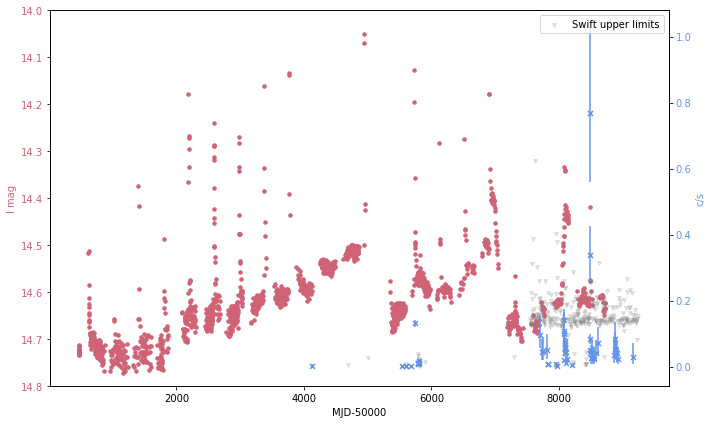

In [164]:
#plot full LC
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.8,14)
# ax1.set_xlim(7000,9000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits',alpha=0.2)
#add error to rate
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],ls='none',color=color)
ax2.legend()

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src60')

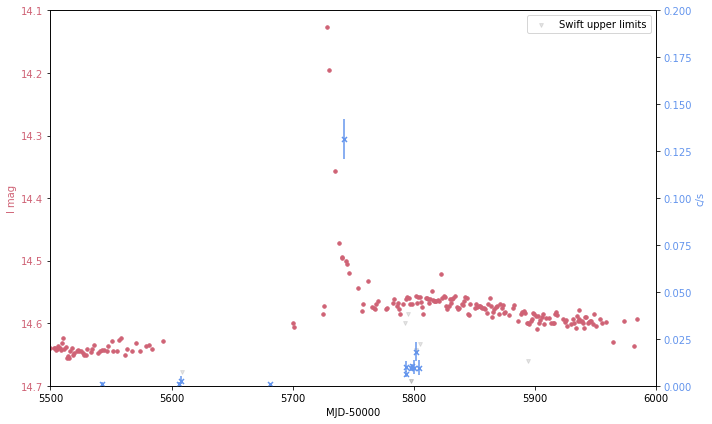

In [165]:
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.7,14.1)
ax1.set_xlim(5500,6000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits',alpha=0.2)
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],ls='none',color=color)

ax2.legend()
ax2.set_ylim(0,0.2)#be mindful of limits b/c this point much lower than later outbursts
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src60_zoom1')

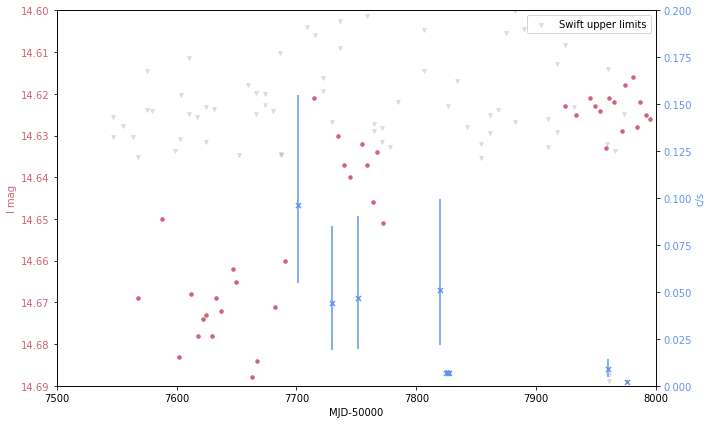

In [166]:
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.69,14.6)
ax1.set_xlim(7500,8000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits',alpha=0.2)
ax2.legend()
ax2.set_ylim(0,0.2)#be mindful of limits b/c this point much lower than later outbursts
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],ls='none',color=color)

fig.tight_layout()
sf('src60_zoom2')

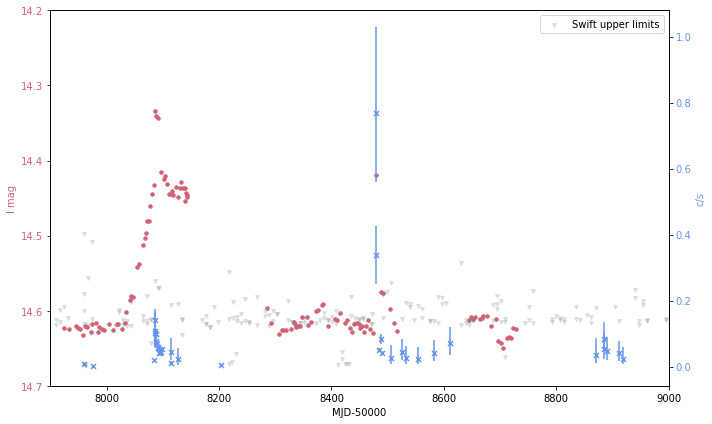

In [167]:
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.7,14.2)
ax1.set_xlim(7900,9000)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits',alpha=0.2)
ax2.legend()
#ax2.set_ylim(0,0.2)#be mindful of limits b/c this point much lower than later outbursts
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],ls='none',color=color)

fig.tight_layout()
sf('src60_zoom3')

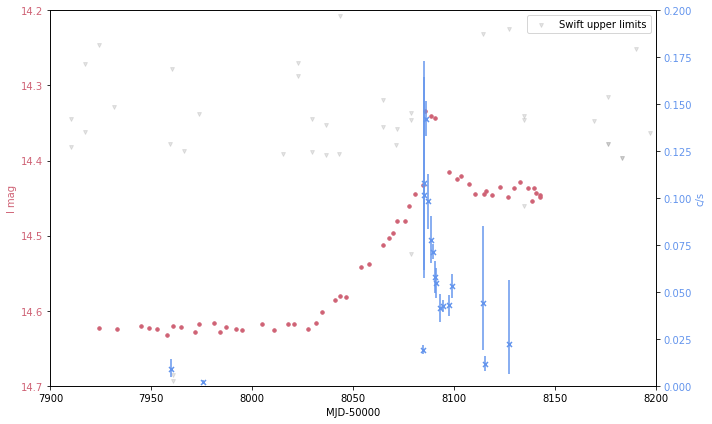

In [168]:
#zooming again from above
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.7,14.2)
ax1.set_xlim(7900,8200)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits',alpha=0.2)
ax2.legend()
ax2.set_ylim(0,0.2)#be mindful of limits b/c this point much lower than later outbursts
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],ls='none',color=color)

fig.tight_layout()
# sf('src60_zoom3')

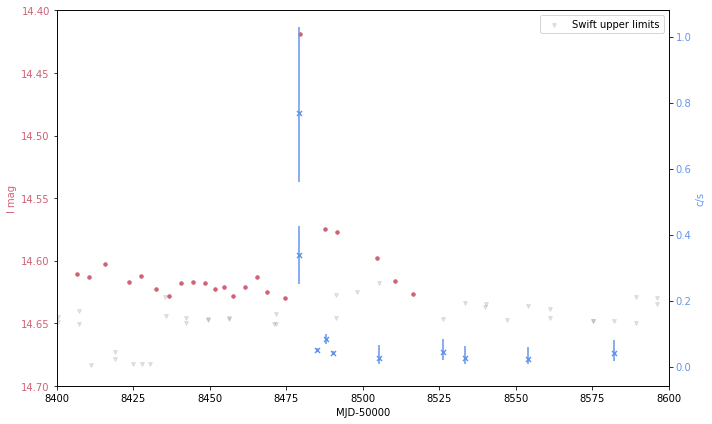

In [169]:
#maybe add errors? interesting that optical doesn't brighten so much but this is brightest X-ray signal
fig, ax1 = plt.subplots(figsize=(10,6))

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.7,14.4)
ax1.set_xlim(8400,8600)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=25,marker='x')
ax2.scatter(dup,rup, color='grey',s=15,marker='v',label='Swift upper limits',alpha=0.2)
ax2.legend()
#ax2.set_ylim(0,0.2)#be mindful of limits b/c this point much lower than later outbursts
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(date,rate,yerr=[rerr_low,rerr],ls='none',color=color)

fig.tight_layout()

# Original Auto Binning
# List Sources with Known Type II outbursts

9, 7 (SXP 6.85), 5 (SXP 4.78), 60 (SXP 756), 6 (SXP 5.05)

# Look for Lags: Source #9

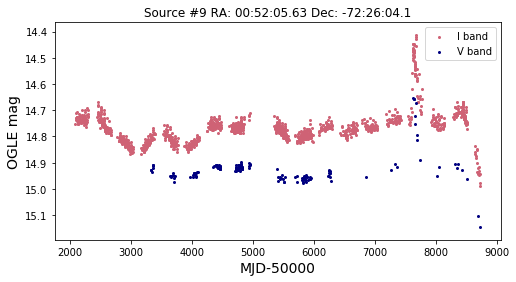

In [63]:
iband,vband = o.getIV(9,cross,stack=True,plot=True)

I and V-I correlation: -0.667340526448103
V and V-I correlation: -0.39477937412506486


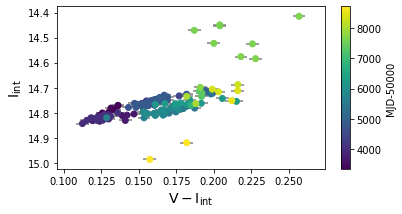

In [64]:
o.colormag(iband,vband,both=False,figsize=(6,3))

In [65]:
#just around outburst
ib = iband[iband['MJD-50000']>7500]
ib = ib[ib['MJD-50000']<8000]
#vband
vb = vband[vband['MJD-50000']>7500]
vb = vb[vb['MJD-50000']<8000]

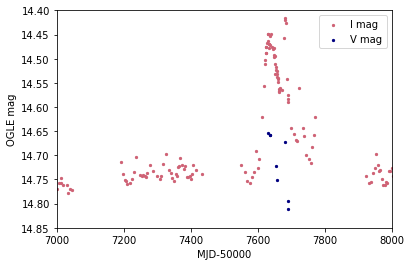

In [76]:
plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=5,label='I mag')
plt.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=5,label='V mag')
plt.legend()
plt.xlim(7000,8000)
plt.ylim(14.85,14.4)
plt.ylabel('OGLE mag')
plt.xlabel('MJD-50000')
sf('src9zoom')

I and V-I correlation: -0.3082900143496301
V and V-I correlation: -0.06326829525957481


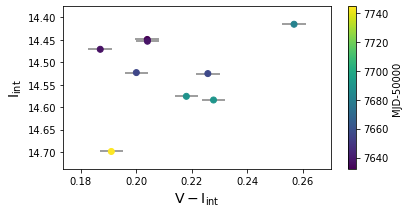

In [53]:
o.colormag(ib,vb,both=False,figsize=(6,3))

In [7]:
#Swift LC
lin = np.loadtxt('Swift_LCs/lin198.txt',skiprows=15,comments='!')

In [8]:
time = lin[:,0]
rate = lin[:,3]
rerr = lin[:,5]#rate error

In [9]:
rate[17830:17841]

array([6.313907e-01, 7.974221e-01, 5.206600e+02, 3.373200e+01,
       1.693000e+03, 1.224700e+02, 3.292600e+01, 3.150900e+00,
       3.299800e+00, 4.213600e+00, 3.722300e+00])

In [10]:
3*u.s.to(u.day)

3.472222222222222e-05

In [11]:
date = time*u.s.to(u.day)+3683.731273

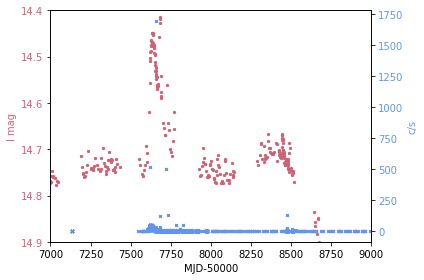

In [15]:
#haven't separated out the upper limits
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.9,14.4)
ax1.set_xlim(7000,9000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

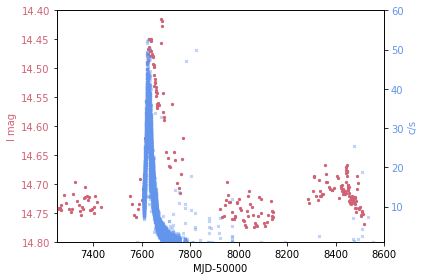

In [33]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.8,14.4)
ax1.set_xlim(7250,8600)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x',alpha=0.4,zorder=1)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=pink,s=5,zorder=100)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(1,60)
fig.tight_layout()
sf('src9')

# Look for Lags: Source 7


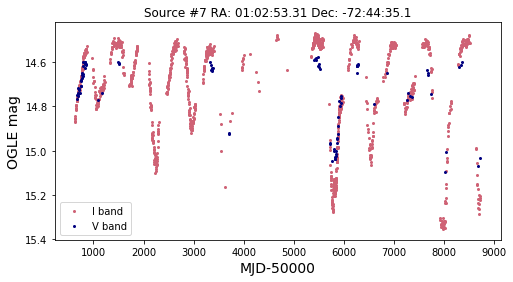

In [34]:
iband,vband = o.getIV(7,cross,stack=True,plot=True)

In [35]:
sx68 = np.loadtxt('Swift_LCs/sxp6.85.txt',skiprows=15,comments='!')
time = sx68[:,0]
rate = sx68[:,3]
rerr = sx68[:,5]

In [36]:
time

array([3.20813004e+08, 3.20813014e+08, 3.20813024e+08, ...,
       3.31979426e+08, 3.31979526e+08, 3.31985326e+08])

In [37]:
#zero point is 55384.535371 MJD
date = time*u.s.to(u.day)+5384.535371

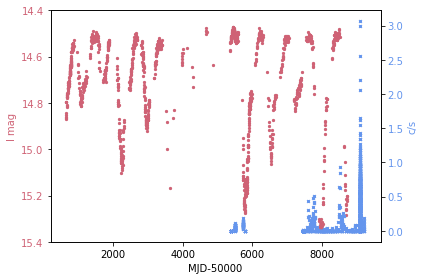

In [39]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.4,14.4)
# ax1.set_xlim(7000,9000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
sf('src7fullx')

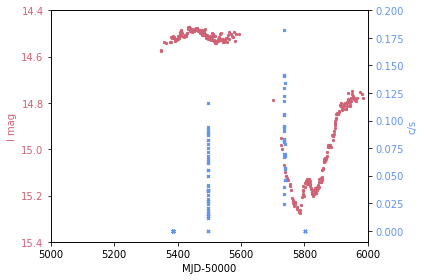

In [45]:
#check if same times as paper, esp since peaks potentially not shown here
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.4,14.4)
ax1.set_xlim(5000,6000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-.01,0.2)
fig.tight_layout()
sf('src7out1')

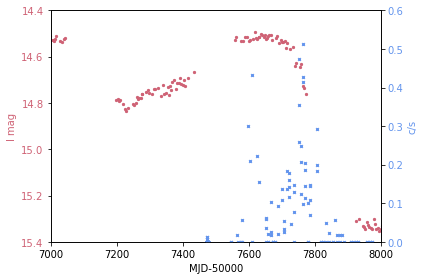

In [46]:
#the two outbursts in a row with once coinciding w/optical peak and one not
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.4,14.4)
ax1.set_xlim(7000,8000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,0.6)
fig.tight_layout()
sf('src7out2')

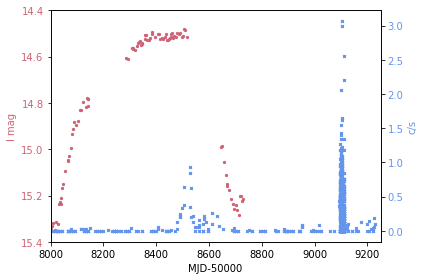

In [47]:
#first lags the optical peak and then no coverage
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.4,14.4)
ax1.set_xlim(8000,9250)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(date,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0,3)
fig.tight_layout()
sf('src7out3')

#### try using evt file

In [5]:
import astropy.visualization.hist as bhist

In [6]:
def readevt(file,index=1,header=False):
    hdu_list = fits.open(file, memmap=True)
    if header: tab = hdu_list[index].header
    else: tab = Table(hdu_list[index].data)
    return tab

In [7]:
pcfile = 'Swift_LCs/sxp6.85pcsourcetotal.evt'
pc = readevt(pcfile)

In [8]:
tint = readevt(pcfile,index=2)
head = readevt(pcfile,index=0,header=True)

In [9]:
def binevt(tab,tint,head,n=100):
    '''
    tab: evt table
    tint: exposure interval table
    n: number of bins'''
    tbins = np.concatenate((tint['START'],tint['STOP']))
    tbins = np.sort(tbins)
    hist = bhist(tab['TIME'],bins=tbins,histtype='step',color='maroon',alpha=.4)
    plt.close()
    bin_wid = hist[1][1:]-hist[1][:-1]
    #total counts in each bin
    #time to use for bin point is middle point in time of bin
    bint = hist[1][:-1]+(bin_wid/2)
    counts = hist[0]
    #take every other bin since the others are between STOP and START
    bint = bint[::2] 
    counts = counts[::2]
    bin_wid = bin_wid[::2]
    #count rate is counts in bin divided by the total time of that bin
    cr = (counts)/bin_wid
    if n==1: 
        mjdref = head['MJDREFI']+head['MJDREFF']-50000
        daybin = bint*u.s.to(u.day) + (mjdref)
        return daybin,cr
    crbin = np.array_split(cr,n)
    binw = np.array_split(bin_wid,n)
    tms = np.array_split(bint,n)
    countsbin = np.zeros(len(crbin))
    bwb = np.zeros(len(crbin))
    tbin = np.zeros(len(crbin))
    for i in range(len(crbin)):
        countsbin[i] = np.sum(crbin[i])
        bwb[i] = np.sum(binw[i])
        #mean time within bin adopted as time for bin
        tbin[i] = np.mean(tms[i])
    mjdref = head['MJDREFI']+head['MJDREFF']-50000
    daybin = tbin*u.s.to(u.day) + (mjdref)
    return daybin,countsbin

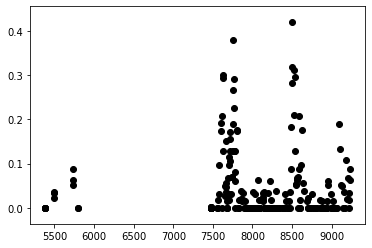

In [10]:
day,cr = binevt(pc,tint,head,n=1000)
plt.scatter(day,cr,color='black')

In [165]:
np.mean(tint['STOP']-tint['START'])

166.94524451250933

In [161]:
#add WT mode file
wtfile = 'Swift_LCs/sxp6.85wtsourcetotal.evt'
wt = readevt(wtfile)
wtint = readevt(wtfile,index=2)
wthead = readevt(wtfile,index=0,header=True)
wtday,wtcr = binevt(wt,wtint,wthead,n=1)

probably would need to use bins *smaller* than exposure intervals to match the automatic LC
- for now, just binned PC mode more

In [164]:
np.mean(wtint['STOP']-wtint['START'])

807.730266491572

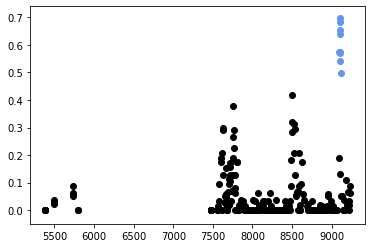

In [167]:
plt.scatter(day,cr,color='black')
plt.scatter(wtday,wtcr,color=blue)

# Look for Lags: Source 5

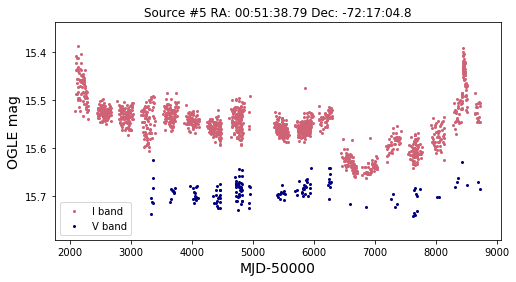

In [54]:
iband,vband = o.getIV(5,cross,stack=True,plot=True)

In [55]:
#swift LC
sx47 = np.loadtxt('Swift_LCs/sxp4.78.txt',skiprows=15,comments='!')
time = sx47[:,0]
rate = sx47[:,3]
rerr = sx47[:,5]

In [56]:
days = time*u.s.to(u.day)+3683.731273

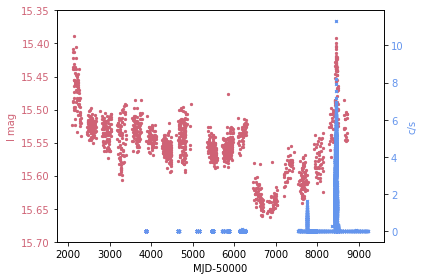

In [58]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.7,15.35)
# ax1.set_xlim(8000,10000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0,3)
fig.tight_layout()
sf('src5fullx')

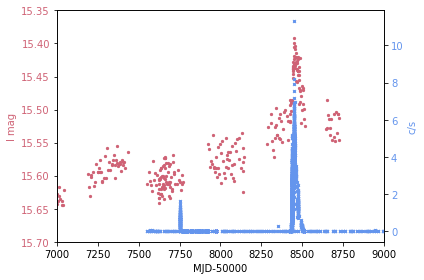

In [59]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.7,15.35)
ax1.set_xlim(7000,9000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0,3)
fig.tight_layout()
sf('src5outs')

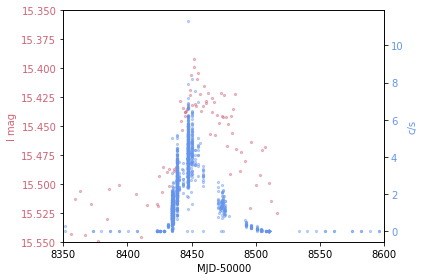

In [62]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5,alpha=0.4)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(15.55,15.35)
ax1.set_xlim(8350,8600)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,alpha=0.4,s=5)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0,3)
fig.tight_layout()
sf('src5out2')

# Look for Lags: Source 60



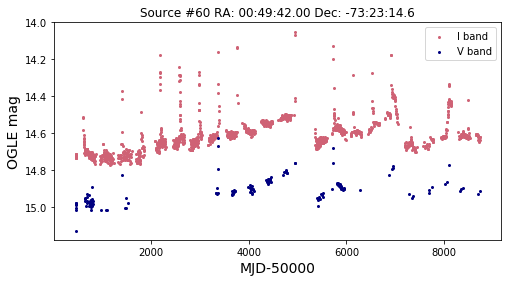

In [77]:
iband,vband = o.getIV(60,cross,stack=True,plot=True)

In [78]:
#swift LC
sx47 = np.loadtxt('Swift_LCs/sxp756.txt',skiprows=15,comments='!')
time = sx47[:,0]
rate = sx47[:,3]
rerr = sx47[:,5]

In [79]:
#convert to days using t0
days = time*u.s.to(u.day)+4125.093753

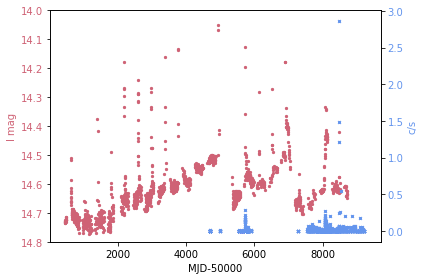

In [81]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.8,14)
# ax1.set_xlim(8000,10000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0,0.5)
fig.tight_layout()
sf('src60fullx')

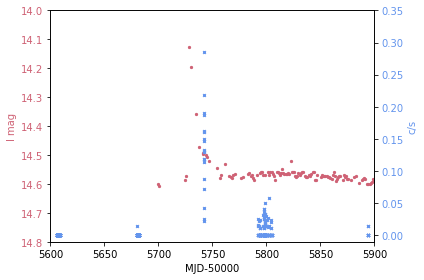

In [85]:
#seems to lag 
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.8,14)
ax1.set_xlim(5600,5900)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-.01,0.35)
fig.tight_layout()
sf('src60out1')

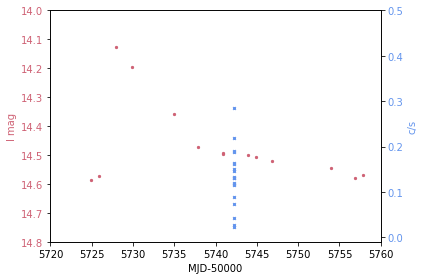

In [40]:
#zoom even more
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.8,14)
ax1.set_xlim(5720,5760)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-.01,0.5)
fig.tight_layout()

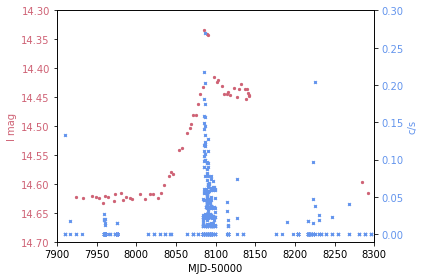

In [88]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.7,14.3)
ax1.set_xlim(7900,8300)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,s=7,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-.01,0.3)
fig.tight_layout()
sf('src60out2')

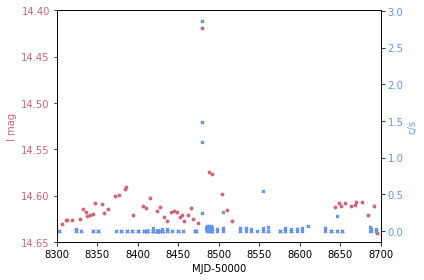

In [94]:
fig, ax1 = plt.subplots()

color = pink
ax1.set_xlabel('MJD-50000')
ax1.set_ylabel('I mag', color=color)
ax1.scatter(iband['MJD-50000'],iband['I mag'], color=color,s=8)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14.65,14.4)
ax1.set_xlim(8300,8700)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = blue
ax2.set_ylabel('c/s', color=color)  # we already handled the x-label with ax1
ax2.scatter(days,rate, color=color,s=8,marker='x')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(-.01,0.3)
fig.tight_layout()
sf('src60out3')

# SXP 5.05
- realized you can set the time axis to MJD

# Periodicity Searches
- change best period column for these sources

ATel for Source #63, which has *Type I* outbursts: 655.9 +/- 0.2 d

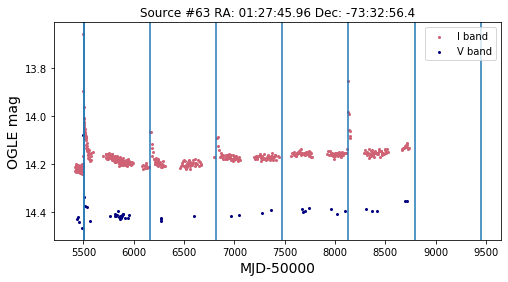

In [79]:
iband,vband = o.getIV(63,cross,stack=True,plot=True)
plt.axvline(5510)
for i in range(7):
    plt.axvline(655.9*i+5510)

(14.3, 13.6)

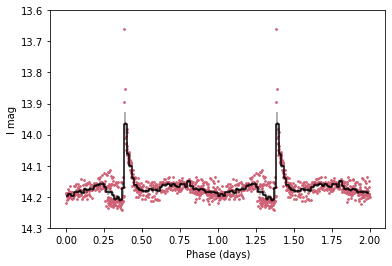

In [80]:
#fold
pd = 655.9
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I mag'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I mag'],color=pink,s=3)
o.phasestep(iband,pd,60,divide=True)
plt.ylim(14.3,13.6)

(14.3, 13.6)

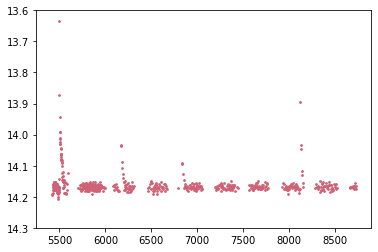

In [81]:
o.splinedetrend(iband,window=300)
plt.scatter(iband['MJD-50000'],iband['I detrend'],color=pink,s=3)
plt.ylim(14.3,13.6)

(14.3, 13.6)

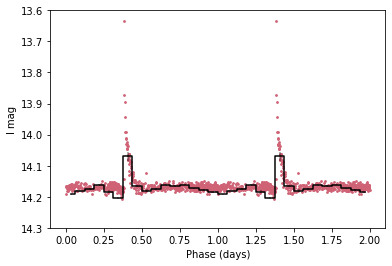

In [82]:
#fold after detrending
pd = 655.9
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3)
o.phasestep(iband,pd,16,divide=True)
plt.ylim(14.3,13.6)

In [83]:
row = summ[summ['src_n']==63]
row['best period'] = 656
summ[summ['src_n']==63] = row

In [84]:
summ[summ['src_n']==63]['best period']

58    656.0
Name: best period, dtype: float64

In [85]:
srcn = 63
pdict = o.combine(srcn,cross,full,iband=iband,pd=656,pbins=16,det=True,close=True,testbins=False)
row = phase[phase['src_n']==srcn]
#loop through keys in pdict and add quantities to df
for d in list(pdict.keys()):
    row[d] = pdict[d]
phase[phase['src_n']==srcn] = row

### search source #60
393.1 +/- 0.4 Schmidtke et al. 2013
- Galache RXTE 389.9 +/- 7.0 days

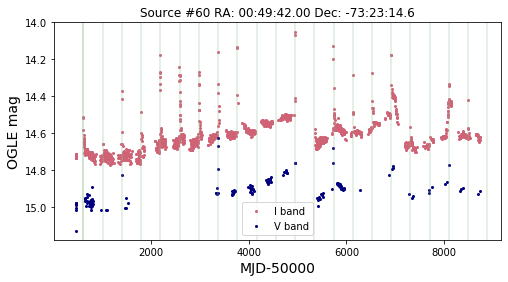

In [86]:
iband,vband = o.getIV(60,cross,stack=True,plot=True)
plt.axvline(625,color='darkseagreen',alpha=0.3)
for i in range(22):
    plt.axvline(393.1*i+625,color='darkseagreen',alpha=0.3)

(15, 14)

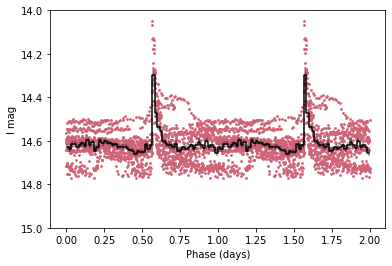

In [87]:
#fold
pd = 393.1
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I mag'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I mag'],color=pink,s=3)
o.phasestep(iband,393.1,60,divide=True)
plt.ylim(15,14)

**for source like this, amplitude strongly affected by bin number since spike so narrow**

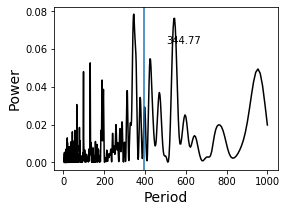

In [88]:
o.periodogram(iband,maxp=1000)
plt.axvline(393) #periodograms just don't really work for this type of source

(15, 14)

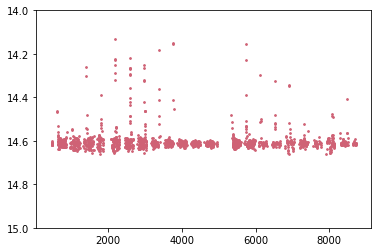

In [89]:
o.splinedetrend(iband,window=300)
plt.scatter(iband['MJD-50000'],iband['I detrend'],color=pink,s=3)
plt.ylim(15,14)

(15, 14)

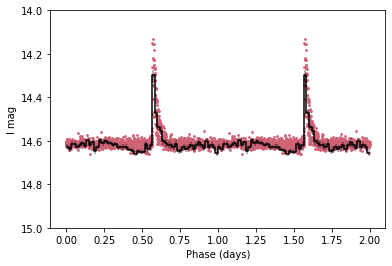

In [90]:
#fold detrended
pd = 393.1
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3)
o.phasestep(iband,pd,60,divide=True)
plt.ylim(15,14)

In [75]:
row = summ[summ['src_n']==60]
row['best period'] = 393
summ[summ['src_n']==60] = row

# Update phase and summary tables

#### update phase table by using these periods in fold

In [91]:
srcn = 60
pdict = o.combine(srcn,cross,full,iband=iband,pd=393,pbins=16,det=True,close=True,testbins=False)
row = phase[phase['src_n']==srcn]
#loop through keys in pdict and add quantities to df
for d in list(pdict.keys()):
    row[d] = pdict[d]
phase[phase['src_n']==srcn] = row

In [93]:
phase[phase['src_n']==63]

,src_n,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err
58,63,656.0,0.104757,0.9375,0.34375,0.40625,not FRED,0.010035,14.162283,-3.571613,10.87291,0.001011,0.002232


In [94]:
phase.to_csv('phasetab.csv',index=False)

In [41]:
summ.to_csv('summtab.csv',index=False)